This python notebook performs aperture photometry on UVIT images processed using the CCDLAB pipeline. This is a simpler python implementation of the aperture photometry function of Gulab's Julia package UVITTools.


Open the CCDLAB processed MASTER_IMAGE fits file in ds9. Identify the source and create a circular region centered on the source centroid. Note the central x and y co-ordinates of the region and write them in the appropriate place in the notebook. Similarly put the details of a source free circular background region (preferably close to the source) in the notebook and then run the notebook.

In [421]:
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.io import fits
from astropy.visualization import simple_norm
from photutils.aperture import ApertureStats, CircularAperture

The following function plots the UVIT image.

In [422]:
def plot_image(image, xlim=None, ylim=None):
    norm = simple_norm(image, stretch='sqrt', percent=99)

    if xlim is not None and ylim is not None:
        
        x_llim, x_ulim = xlim
        y_llim, y_ulim = ylim
        image = image[y_llim:y_ulim, x_llim:x_ulim]   
        plt.imshow(image, norm=norm, interpolation='none', origin='lower')

    else:
        plt.imshow(image, norm=norm, interpolation='none', origin='lower')

The following function performs aperture photometry using a circular aperture.

In [423]:
def aphot(data, xcen, ycen, radius, return_area=False):
    
    aperture = CircularAperture((xcen, ycen), r=radius)
    aperstats = ApertureStats(data, aperture)
    val = aperstats.sum
    val_err = np.sqrt(val)
    aperture_area = aperstats.sum_aper_area
    
    if return_area == True:
        return val, val_err, aperture_area
    elif return_area == False:
        return val, val_err

Function to calculate background corrected source count rate using the aphot function

In [424]:
def do_photometry(image_data, exp_time=1):

    src_cts, src_err, src_area = aphot(image_data, src_xcen,
                                    src_ycen, src_aper_rad,
                                    return_area=True)

    bkg_cts, bkg_err, bkg_area = aphot(image_data, bkg_xcen,
                                    bkg_ycen, bkg_aper_rad,
                                    return_area=True)

    area_scale = (src_area/bkg_area)
    bkg_cts = bkg_cts * area_scale
    bkg_rate = bkg_cts/exp_time
    bkg_rate_err = np.sqrt(bkg_cts)/exp_time

    src_rate = src_cts/exp_time
    src_rate_err = np.sqrt(src_cts)/exp_time

    net_src_rate = (src_cts - bkg_cts)/exp_time
    net_src_rate_err = np.sqrt(src_rate_err**2 
                        + bkg_rate_err**2)
    
    return net_src_rate, net_src_rate_err

Following function supplies the zero point magnitudes and mean wavelengths for the various UVIT channels and filters. Data from Tandon et al. (2017, 2020). The following two functions are adaptions from Gulab's UVITTools.

In [425]:
def uvit_lm_uc_zp(channel, filter):
    
    if channel == 'FUV':
        if filter == 'F1' or filter == 'CaF2' or filter == 'F148W':
            zp = (18.097, 0.010)
            λ_mean = 1481
        elif filter == 'F2' or filter == 'BaF2' or filter == 'F154W':
            zp = (17.771, 0.010)
            λ_mean = 1541
        elif filter == 'F3' or filter == 'Sapphire' or filter == 'F169M':
            zp = (17.410, 0.010)
            λ_mean = 1608
        elif filter == 'F5' or filter == 'Silica' or filter == 'F172M':
            zp = (16.274, 0.020)
            λ_mean = 1717
        
    elif channel == 'NUV':
        if filter == 'F1' or filter == 'Silica-1' or filter == 'N242W':
            zp = (19.763, 0.002)
            λ_mean = 2418
        elif filter == 'F2' or filter == 'NUVB15' or filter == 'N219M':
            zp = (16.654, 0.020)
            λ_mean = 2196
        elif filter == 'F3' or filter == 'NUVB13' or filter == 'N245M':
            zp = (18.452, 0.005)
            λ_mean = 2447
        elif filter == 'F5' or filter == 'NUVB4' or filter == 'N263M':
            zp = (18.146, 0.010)
            λ_mean = 2632
        elif filter == 'F6' or filter == 'NUVN2' or filter == 'N279N':
            zp = (16.416, 0.010)
            λ_mean = 2792
    
    uc = 10**(-0.4 * (zp[0] + 2.407))/λ_mean**2
    uc_err = np.abs(1/λ_mean**2 * -0.10034
             * np.exp((-0.921034 * zp[0])) * zp[1])
    uc = (uc, uc_err)

    return λ_mean, uc, zp

The following function calculates the flux and magnitude from the count rate obtained by aperture photometry.

In [426]:
def ctr2flux_mag(channel, filter, cps, cps_err):
    
    Lambda_Mean, UC, ZP = uvit_lm_uc_zp(channel, filter)
    f_λ = cps * UC
    f_λ_err = np.sqrt((cps_err/cps)**2 + (UC[1]/UC[0])**2) * f_λ
    Magnitude = -2.5*np.log10(cps) + ZP[0]
    Magnitude_Err = np.sqrt(6.25*(cps_err/cps)**2 + ZP[1]**2)
    Magnitude = (Magnitude, Magnitude_Err)

    return Lambda_Mean, f_λ, Magnitude

Enter the image file name, source and background aperture details and run the notebook.
The aperture details can be taken from DS9 regions.

In [427]:
image_filename = 'meg-6-30-15_FUV_CaF2___MASTER_IMAGE_archive.fits'

src_xcen, src_ycen = 3093.7362, 1824.4386
src_aper_rad = 25

bkg_xcen, bkg_ycen = 3246.7097, 1758.9792 
bkg_aper_rad = 60

In [428]:
hdul = fits.open(image_filename)
image_data = hdul[0].data
image_header = hdul[0].header
hdul.close()

source_id = image_header['SOURCEID']
instrument = image_header['INSTRUME']
channel = image_header['DETECTOR']
filter = image_header['FILTERID']
exp_time = image_header['EXP_TIME']
mean_obs_bjd = image_header['MEANBJD']

cts, err = do_photometry(image_data, exp_time)

l_mean, f_lambda, magnitude = ctr2flux_mag(channel, filter, cts, err)

print('*******************************************************************')
print(f'source: {source_id}')
print(f'instrument: {instrument}')
print(f'channel: {channel}')
print(f'filter: {filter}')
print(f'Mean wavelength (Å): {l_mean}')
print(f'Net exposure time (s): {exp_time}')
print(f'Mean BJD of observation: {mean_obs_bjd}')
print(f'Net count rate (ct/s): {cts} +/- {err}')
print(f'f_λ (erg/cm^2/s/Å): {f_lambda[0]} +/- {f_lambda[1]}')
print(f'Magnitude (AB system): {magnitude[0]} +/- {magnitude[1]}')
print('*******************************************************************')

*******************************************************************
source: meg-6-30-15
instrument: UVIT
channel: FUV
filter: CaF2
Mean wavelength (Å): 1481
Net exposure time (s): 6029.748
Mean BJD of observation: 2459045.9928806
Net count rate (ct/s): 0.27921039144459947 +/- 0.008605070879954397
f_λ (erg/cm^2/s/Å): 8.002422197367445e-16 +/- 7.370481314276836e-18
Magnitude (AB system): 19.48217105624802 +/- 0.07769450221452258
*******************************************************************


Plotting the entire image along with the source and background apertures.

Text(0.5, 1.0, 'Whole Image')

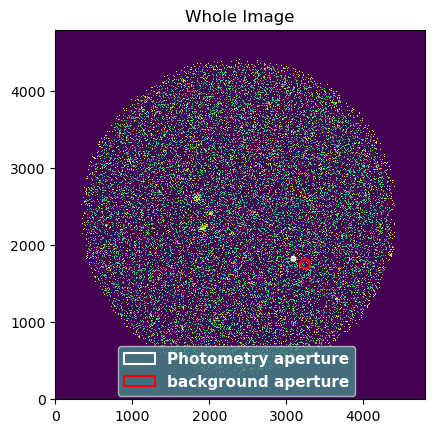

In [429]:
plot_image(image_data)
aperture1 = CircularAperture((src_xcen, src_ycen), r=25)
aperture2 = CircularAperture((bkg_xcen, bkg_ycen), r=60)
ap_patches1 = aperture1.plot(color='white', lw=1.5,
                           label='Photometry aperture')
ap_patches2 = aperture2.plot(color='red', lw=1.5,
                           label='background aperture')

handles = (ap_patches1[0], ap_patches2[0])
plt.legend(loc=(0.17, 0.01), facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})
plt.title('Whole Image')

Plotting the zoomed-in view of the source and background with apertures.

Text(0.5, 1.0, 'Source + background zoomed-in view')

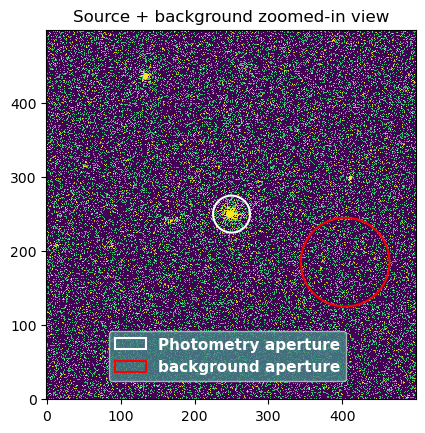

In [430]:
k = 250
x_llim, x_ulim = int(src_xcen - k), int(src_xcen + k)
y_llim, y_ulim = int(src_ycen - k), int(src_ycen + k)

xlim = (x_llim, x_ulim)
ylim = (y_llim, y_ulim)
new_bkg_xcen, new_bkg_ycen = bkg_xcen - x_llim, bkg_ycen - y_llim

plot_image(image_data, xlim, ylim)

src_pos, bkg_pos = [(k, k)], [(new_bkg_xcen, new_bkg_ycen)]
aperture1 = CircularAperture(src_pos, r=25)
aperture2 = CircularAperture(bkg_pos, r=60)
ap_patches1 = aperture1.plot(color='white', lw=1.5,
                           label='Photometry aperture')
ap_patches2 = aperture2.plot(color='red', lw=1.5,
                           label='background aperture')

handles = (ap_patches1[0], ap_patches2[0])
plt.legend(loc=(0.17, 0.05), facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})
plt.title('Source + background zoomed-in view')